# Notebook 2 - Machine Learning
## Opening Range Algorithmic Trading Example
### Version 0.1.6
#### 06/25/2025
_____________________________________________________________________________________________________________________________________________________________________


# Strategy Summary (RECAP)
This is an entry level trading strategy based on an opening range breakout. This trading algorithm is not designed to generate alpha. It is designed to demonstarte my skillset in software engineering, backesting, machine learning and financial analysis. This strategy measures the 5' high and low and if the price breaks the high, we take it for a price target, if the price breaks the low we take it for a price target. 

If the first trade fails, we give it a second chance if it retriggers. The risk is the opposite high/low of the operning range bar. From our previous notebook, we have found that the mini NASDAQ futures contract (MNQ) is the most profitable, albeit quite volatile. We will use that contract for our machine learning to see if we can pull out any additional performance of our model. 

# Machine Learning

Now that we have a good sample of trades from our strategy, we can start looking for hints as to whether we can predict if the trade will work or not before we actually take the trade. Currently, we are looking at a win percentage of approximately 40% with a 2:1 reward to risk ratio. That has resulted in substantial profits. At the time of writing this section, it was $10,500 in 466 trades (188 wins) to be exact. That means that we are making approximately $56 per trade. If we can improve our batting average even slightly, our profits could see dramatic growth.

Let's take an example, if we risk $150 on average and we take 100 trades with a batting average of 40% we would make $3,000. If we improve the batting average by just 5 out of 100 trades, we would make $5,250. That's an incredible improvement in profits. If we can get up to 50% thats more than double the profifts, $7,500 in profit in 100 trades.

So how can we go about doing that. We need to start by finding features that may help us predict the price movement before it happens. We will then need to transform the data depending on the models that we use. We will then decide on which model best suits our data and tune the parameters to get the best possible predictive ability we can. We will compare this to a dummyClassifier that classifies at random to see whether we get any improvement. We will continue to add remove features and train the model as we get more data and insights. So, let's get started

## Design
### Feature Engineering
#### Target Label
- ✅ Our target label will be Win as the positive class (1) and a loss as the negative class (0)
- Multi-class: 2R 3R 1R profit targets etc.
- Early Exit Classifier to run while in a position
#### Features
Quantitative Continuous:  
- ✅ Volume of the 5 min bar 
- ✅ Normalized volume (20 period moving average of 5 min bars) 
- ✅ Size of bar (absolute dollar value)  
- ✅ Size of bar Normalized (% of asset opening price)
- ✅ % Gap from previous close
- ✅ Size of Bottoming tail (normlaized)  
- ✅ Size of Topping tail (normalized)
- ✅ Distance from yesterdays AVWAP
- ✅ 90 period 5'Simple Moving Average
- ✅ 90 period 5'Simple Moving Average Slope
- Moving average increasing/decreasing/neutral (measuresd by difference between most recent bars)
- VWAP increasing/decreasing/neutral (measured by difference between most recent bars)  

Categorical Binary:  
- ✅ SHORT/LONG (Binary) (wont know this at time of decision so will have to test both before entrering trade)
- ✅ Gap Up/Gap Down (gap % is a better feature)  
- ✅ Inside Day Body (Binary)
- ✅ Inside Day Wicks (Binary)  

Multi-Class Categorical (One Hot Encoding):    
- ✅ Day of the Week

Other Indicators?  
- RSI?  
- MACD?  

### Model Classifers  
- kNN Classifier  
- Logisitc Regression (lasso or Ridge)
- Decision Tree (Feature Selection)
- Random Forest
- Gardient Boosted Descision Tree

### Model Evaluation Metrics
- Precision (limit False Positives because they cost money) *GridSearch Evaluation Metric
- Confusion Matrix
- F1 Score
- Precision Recall Curve
- ROC Curve AUC score

## Section 1: Importing Libraries
It is important to note that this notebook uses a private internal library 'River Rose'. Code is not provided publicly for compliance and security reasons.

### Importing Libraries

In [70]:
#import our libraries
import numpy as np
import pandas as pd
import RiverRose as rr
import RiverRose.technical_analysis as rrt
import RiverRose.kpi as rrk
import RiverRose.graphing as rrg
import sqlalchemy as pg
import matplotlib.pyplot as plt

#Import all of our SciKit-Learn 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score, recall_score, accuracy_score, roc_auc_score

#Import our packages for Deep Learning
#from keras.models import Sequential  
#from keras.layers import Dense  
#from keras.wrappers.scikit_learn import KerasClassifier

#import packages for saving and loading the model
#from pickle import dump 
#from pickle import load

## Section 2: Load Trading Dataframe
Let's start by bringing in all of the trading data that we obtained in 'Notebook 1 - Backtesting Opening Range Strategy.ipynb'.

In [71]:
ml_df = pd.read_csv('mnq_backtesting_data.csv')
print(f"We have a dataframe of {ml_df.shape[0]} trades with {ml_df.shape[1]} features for supervised machine learning\n")
ml_df.info()

We have a dataframe of 360 trades with 20 features for supervised machine learning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         360 non-null    int64  
 1   timestamp          360 non-null    object 
 2   date               360 non-null    object 
 3   time               360 non-null    object 
 4   target_label       360 non-null    int64  
 5   day                360 non-null    object 
 6   transaction        360 non-null    float64
 7   volume_5min        360 non-null    float64
 8   volume_norm        360 non-null    float64
 9   barsize_5min       360 non-null    float64
 10  barsize_5min_norm  360 non-null    float64
 11  topping_tail       360 non-null    float64
 12  bottoming_tail     360 non-null    float64
 13  inside_wicks       360 non-null    float64
 14  inside_body        360 non-null    flo

We now have a feature set of 10-15 normalized features that I think will do a pretty good job of giving characteristics to the trade. It's hard to tell if they will have any predictive power but there is only one way to find out. Now that we have our feature dataframe, there is just a little more that we need to do. We need to OneHotEncode the 'day' column. Because we are already working in pandas, let's just use the get dummies method. Everything else should be pretty staright forward as either continuous quantitative or binary categorical.

In [72]:
ml_df = pd.get_dummies(ml_df, columns=['day'],dtype=int)
ml_df.drop(columns=['Unnamed: 0'],inplace=True)
ml_df.head()

,timestamp,date,time,target_label,transaction,volume_5min,volume_norm,barsize_5min,barsize_5min_norm,topping_tail,...,sma_90_norm,sma_90_slope,avwap_2day,gap,gap_up,day_Friday,day_Monday,day_Thursday,day_Tuesday,day_Wednesday
0,2023-12-13 07:35:00,2023-12-13,07:35:00,0,1.0,29617.0,0.870826,40.00,0.23,0.0072,...,1.0132,0.0228,0.0450,1.01,1,0,0,0,0,1
1,2023-12-14 07:40:00,2023-12-14,07:40:00,0,1.0,29997.0,0.882998,47.75,0.27,0.0686,...,1.0118,0.0280,0.1056,0.24,1,0,0,1,0,0
2,2023-12-15 07:35:00,2023-12-15,07:35:00,0,1.0,32782.0,0.980852,39.75,0.23,0.1518,...,1.0018,-0.0007,0.1322,0.19,1,1,0,0,0,0
3,2023-12-18 07:35:00,2023-12-18,07:35:00,1,1.0,31228.0,0.930532,41.00,0.23,0.0400,...,1.0015,0.0088,0.0112,0.16,1,0,1,0,0,0
4,2023-12-19 07:40:00,2023-12-19,07:40:00,1,1.0,32376.0,0.964989,44.75,0.25,0.0766,...,1.0023,0.0099,0.0865,0.09,1,0,0,0,1,0


## Section 3: Base Supervised Learning Model Performance
It is important that we don't have any data leakage in this step of the process, we will use the industry standard of train, validate, test. So we will begin by splitting the data into a train/test set and move the test set aside until final model evaluation. Within the training set, we will use cross validation in order to get the best genearlization of the model that we can. Because our batting average is not equal (about 35-40% for positive class) we will stratify the split so that we can accurately predict the test case.

Let's create a box for the dynamic variables in our model selection and testing. This will allow us to easily manipulate these variables one time to adjust all of the following outputs.

## Section 4: Dynamic Machine Learning Variables

In [73]:
#Seperate Buy/Sell Side? (Buy, Sell, None)
buy_sell_side = 'None'

#Train-Test-Split Size and random_state
validation_size = 0.20
split_seed = 6
#Data Scalar ('None', 'Standard', 'MinMax')
scaler_type = 'MinMax'
scaler_list = ['volume_5min','volume_norm','barsize_5min','barsize_5min_norm','topping_tail','bottoming_tail','sma_90_norm','sma_90_slope',
               'avwap_2day','gap']

#Model Random_State
model_seed = 6

#Cross Validation Folds
folds = 5

#Evaluation metric (recall, precision, accuracy, roc_auc)
scoring = 'recall'

One of the first things we need to do is to assess the balance in our target_label class. If the samples are significantly unbalanced we will need to either under or oversample in order to balance the dataset. Let's take a look at the balance of our binary dependent variable.

In [74]:
class_names = {0:'Stopped',1:'Profit'}
counts = ml_df['target_label'].value_counts().rename(index = class_names)
print(counts)
print(f"\nwe had {counts.iloc[1]/counts.sum():.2%} success rate")


target_label
Stopped    215
Profit     145
Name: count, dtype: int64

we had 40.28% success rate


In our current version of the notebook, we have 185 samples in the negative class and 134 samples in the positive class. This isn't terribly unbalanced (42%/58%) however, we can probably still benefit from addressing the imbalances in the group. We can either undersample the negative class (reducing our sample size) or we can oversample our positive class (repeating measures).

### Undersampling
This can be faster training if we have a large dateset and it will balance the model but we will be discarding potentially useful data. We can use ranom undersampling or NearMiss which selects majority samples that are closest to the minority class

### Oversampling
Here we duplicate or synthetically generate positive samples. This will preserve all of the data but it risks overfitting if we are duplicating the data. We can use random oversampling or SMOTE (synthetic Minority over sampling technique) which generates synthetic samples based on feature space similarities.

In [75]:
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

#rand_us = RandomUnderSampler(random_state = split_seed)
#X_resampled, y_resampled = rand_us.fit_resample(X,y)

#nm_us = NearMiss()
#X_rasampled, y_resampled = nm_us.fit_resample(X,y)

#rand_os = RandomOverSampler(random_state=split_seed)
#X_resampled, y_resampled = rand_os.fit_resample(X,y)

#smote = SMOTE(random_state = split_seed)
#X_resampled, y_resampled = smote.fit_resample(X,y)

However, in our case, and with our relatively balanced group, we can likely just set the class_weight parameters in our linear classifiers to 'balanced' using the scikit - learn package. So we will do that for now and if things change we can try SMOTE in order to keep our sample size large enough.

Let's start by splitting our data into training and testing dataframes so that we have an untainted testing group to assess model performance.

In [76]:
#Let's filter the data down to only buy side transactions
if buy_sell_side.lower() == 'buy':
    buy_df = ml_df[ml_df['transaction']==1.0]
    n = 5
elif buy_sell_side.lower() == 'sell':
    buy_df = ml_df[ml_df['transaction']==0.0]
    n = 5
else:
    buy_df = ml_df
    n = 4

#Let's create our feature dataframe and our target label Series
X = buy_df.iloc[:,n:]
y = buy_df.iloc[:,3]

#Let's split our Training and Test set. We will not touch the test set until our model is trained and validated
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = validation_size, random_state=split_seed, stratify = y)
print(f"Training Set Length: {len(X_train)}; Test Set Length: {len(X_test)}")

Training Set Length: 288; Test Set Length: 72


The first thing that we need to do is build a dummy classifier that we can compare against. We will build a few dummy classifiers as they are easy. One the predicts the majority, one that is stratified. This will be our baseline comparison. Let's put these values into a dataframe so we can compare them later.

In [77]:
dummy_majority = DummyClassifier(strategy = 'most_frequent',random_state=model_seed).fit(X_train,y_train)
y_predict = dummy_majority.predict(X_test)
print(f"Majority Class Dummy: \n\nAccuracy: {np.round(dummy_majority.score(X_test,y_test),3)} \nPrecision: {np.round(precision_score(y_test,y_predict),3)} \nRecall: {np.round(recall_score(y_test,y_predict),3)}\nROCAUC: {np.round(roc_auc_score(y_test,y_predict),3)}\n")

print(f"Confusion Matix: \n{confusion_matrix(y_test,y_predict)}")

#Let's create a dataframe that we can add our scores to
model_scores = pd.DataFrame([{'Model':'Dummy Majority','Accuracy':np.round(dummy_majority.score(X_test,y_test),3), 'Precision':np.round(precision_score(y_test,y_predict),3),'Recall':np.round(recall_score(y_test,y_predict),3),'ROCAUC':np.round(roc_auc_score(y_test,y_predict),3)}])
model_scores.head()

Majority Class Dummy: 

Accuracy: 0.597 
Precision: 0.0 
Recall: 0.0
ROCAUC: 0.5

Confusion Matix: 
[[43  0]
 [29  0]]


c:\Users\tmacp\anaconda3\envs\QuantFinance\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tmacp\anaconda3\envs\QuantFinance\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.0,0.0,0.5


In [78]:
dummy_strat = DummyClassifier(strategy='stratified',random_state=model_seed).fit(X_train,y_train)
y_predict = dummy_strat.predict(X_test)
print(f"Stratified Class Dummy: \n\nAccuracy: {np.round(dummy_strat.score(X_test,y_test),3)} \nPrecision: {np.round(precision_score(y_test,y_predict),3)} \nRecall: {np.round(recall_score(y_test,y_predict),3)}\nROCAUC: {np.round(roc_auc_score(y_test,y_predict),3)}\n")

print(f"Confusion Matix: \n{confusion_matrix(y_test,y_predict)}")
model_scores2 = pd.DataFrame([{'Model':'Dummy Stratified','Accuracy':np.round(dummy_strat.score(X_test,y_test),3), 'Precision':np.round(precision_score(y_test,y_predict),3),'Recall':np.round(recall_score(y_test,y_predict),3),'ROCAUC':np.round(roc_auc_score(y_test,y_predict),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

Stratified Class Dummy: 

Accuracy: 0.5 
Precision: 0.405 
Recall: 0.517
ROCAUC: 0.503

Confusion Matix: 
[[21 22]
 [14 15]]


,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503


This gives us a good idea of the baseline of just random guesses in our model and what we need to beat with our classification algorithms. This shouldn't be too difficult. The first thing that we are going to do is apply a scalar to all our our quantitative columns so that we don't have abnormally weighed coefficients in our model that may mess up our analysis in some of the simpler linear models. 

If our data is normally distributed and we are using logistic regression the standardScalar() may be most benficial. When we want bounded data (between 0 and 1) for neural networks, we will want to use minMaxScalar. It may be best to try both and see which works best. Ultimatley, I will choose the best scalar and add it to my final Machine Learning Pipeline when exporting it using pickle.

In [79]:
if scaler_type.lower() == 'standard':
    scaler = StandardScaler()
    X_train[scaler_list] = scaler.fit_transform(X_train[scaler_list])
    X_test[scaler_list] = scaler.transform(X_test[scaler_list])
elif scaler_type.lower() == 'minmax':
    scaler = MinMaxScaler()
    X_train[scaler_list] = scaler.fit_transform(X_train[scaler_list])
    X_test[scaler_list] = scaler.transform(X_test[scaler_list])

Now that we have addressed the scaling of our data, we should be able to implement it in all of our classification models to determine which baseline model has the best outcome for our usecase. In this instance, we are likely going to be looking for maximization of either the recall or the auc_roc_score. So let's move forward with this. Let's set up an iterative list of models that we want to test with baseline parameters.

In [80]:
#Let's instantiate a list to contain all of our models
models = []

#Let's put all of the models in
#Basic Models
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(max_iter = 2000)))
#Neural Networks
models.append(('NN', MLPClassifier(max_iter = 1000)))
#Boosting Methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
#Bagging Methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
#Future work will Set up Keras Neural Networks

Now that we have all of our models set up in a nice list. Let's itearte through and calculate the mean and standard devaition through a cross validation test with the data. This will allow us to quickly plot and view the results of the different models with baseline parameters on our problem in question. The big thing we are looking for here is whether or not our classification problem appears to be linear or non-linear based on model performance.

In [81]:
#Instantiate our results list and a list of the names of the models
results = []
names = []

#Iterate through to perform cross validation tests
for name, model in models:
    kfold = KFold(n_splits = folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean().round(4)} ({cv_results.std().round(4)})")

LR: 0.097 (0.0235)
LDA: 0.2439 (0.0664)
KNN: 0.3243 (0.0509)
CART: 0.4253 (0.0833)
NB: 0.243 (0.1471)
SVM: 0.115 (0.0399)


c:\Users\tmacp\anaconda3\envs\QuantFinance\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tmacp\anaconda3\envs\QuantFinance\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tmacp\anaconda3\envs\QuantFinance\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


NN: 0.3613 (0.0631)
AB: 0.2892 (0.0648)
GBM: 0.3967 (0.0255)
RF: 0.2579 (0.0339)
ET: 0.3184 (0.0702)


Finally, we can plot these as box and whisker plots to see how they perform compared to each other based on the scoring technique.

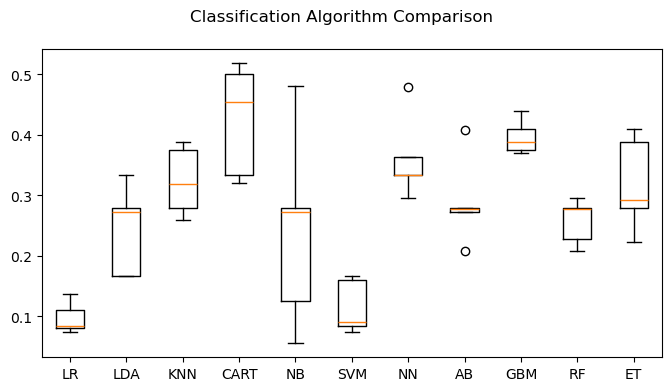

In [82]:
fig = plt.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
plt.show()

## Section 5: Tuning Supervised Models
Based on this information, it actually looks like our Logistic Regression model shows the best fit. It's important to note that we still have quite a bit of standard deviation in our cross_validation scores. So we need to try and optimize this model to get the best perfromance out of it. Let's perform a grid search to see if we can improve the model and then take a look at some of the metrics and confusion matrix.

In [83]:
#Let's set the values of the parameters we want to tune. 
grid_values = {'C':[0.01,0.1,1,10],
              'penalty':['l1','l2']}
grid_clf = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter = 1000,solver='saga', random_state = model_seed), param_grid=grid_values,scoring=scoring,cv=folds)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.6
Best Params: {'C': 0.01, 'penalty': 'l1'}


Okay, 0.6 recall actually seems quite good but before we get ahead of ourselves we should look at the confusion matrix and see what we are finding here.

In [84]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Logistic Regression','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500


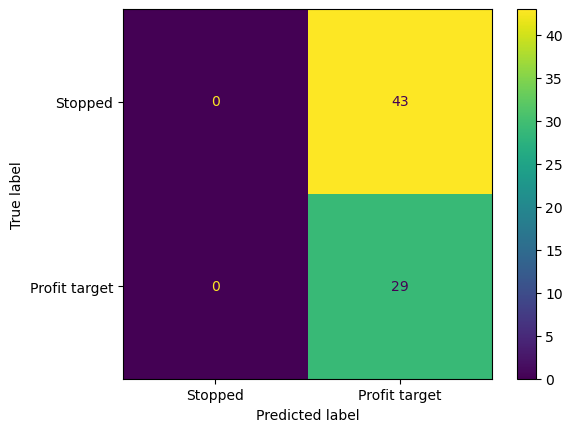

In [85]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

Well, we can see that it just predicted all trades are going to hit profit, so it is no better than our actual model. Now, let's assume an actual trading strategy that aligns with our current trading strategy. That is, a 2:1 reward to risk for each trade. Let's take a look at how our procedure would do compared to no modelling. We will use the accuracy from our dummy classifier (always predicting the minortity) to estimate our batting average and calculate our net return, assuming $1.50 per transaction.

In [86]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $2142.0
This resulted in a net profit of $0.0 by implementing our machine learning model


Let's take a look at Kernalized Support Vector Machines as that shows potential with four out of 5 folds being pretty high recall.

In [87]:
grid_values = {'C': [0.01,0.1,1,10,100],
               'degree': [1,2,3,4,5,6,7,8,9,10]}
grid_clf = GridSearchCV(SVC(kernel='poly',random_state=model_seed),param_grid=grid_values,scoring=scoring,cv=folds)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.5514492753623188
Best Params: {'C': 100, 'degree': 2}


In [88]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Support Vector Machine','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500
3,Support Vector Machine,0.500,0.379,0.379,0.500


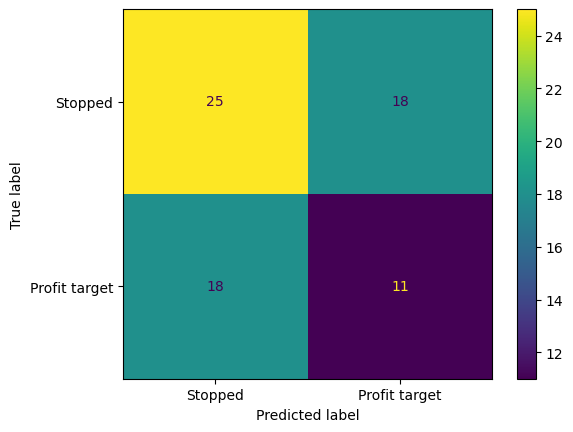

In [89]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

In [90]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $556.5
This resulted in a net profit of $-1585.5 by implementing our machine learning model


That really is not very good. Let's take a look at something that is not linear and see if we can get better results after tuning. I am going to choose one of the ensemble techniques. Lets start with the random forest as that is one that I am much more comfortable with.

In [91]:
#Set up our grid search
grid_values = {'max_features': [4,5,6,7],
               'n_estimators': [5,10,20,50,100],
               'max_depth': [2,3,4,5]}
clf = RandomForestClassifier(n_jobs = -1, random_state = model_seed)
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scoring)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.33659420289855074
Best Params: {'max_depth': 4, 'max_features': 4, 'n_estimators': 5}


In [92]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Random Forest','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500
3,Support Vector Machine,0.500,0.379,0.379,0.500
4,Random Forest,0.542,0.400,0.276,0.427


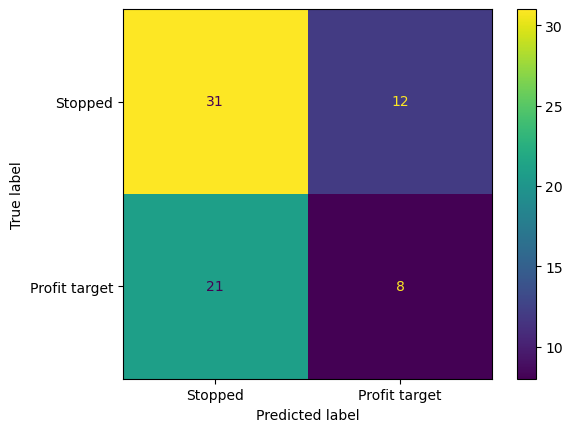

In [93]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

In [94]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $570.0
This resulted in a net profit of $-1572.0 by implementing our machine learning model


Still not great, can we get any imporvement using a gradient boosted tree?

In [95]:
#Set up our grid search
grid_values = {'max_features': [4,5,6,7],
               'n_estimators': [5,10,20,50,100],
               'max_depth': [2,3,4,5]}
clf = GradientBoostingClassifier(random_state = model_seed)
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scoring)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.38840579710144923
Best Params: {'max_depth': 5, 'max_features': 5, 'n_estimators': 100}


In [96]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Gradient Boosted Trees','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500
3,Support Vector Machine,0.500,0.379,0.379,0.500
4,Random Forest,0.542,0.400,0.276,0.427
5,Gradient Boosted Trees,0.514,0.364,0.276,0.412


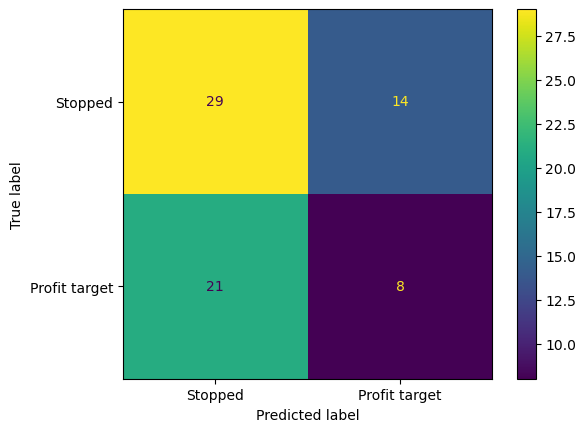

In [97]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

In [98]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $267.0
This resulted in a net profit of $-1875.0 by implementing our machine learning model


Finally, let's take a quick look at two form of neural networks to see if we can get any further information. We will start with a simple shallow neural network and then also look at a deep neural network.

In [99]:
#Set up our grid search
grid_values = {'hidden_layer_sizes': [[7],[8],[9],[10],[11]],
               'alpha': [0.01,0.1,1,5,10]}
clf = MLPClassifier(max_iter=8000,solver='lbfgs',random_state = model_seed)
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scoring)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.5079710144927536
Best Params: {'alpha': 0.01, 'hidden_layer_sizes': [7]}


In [100]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Shallow Neural Network','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500
3,Support Vector Machine,0.500,0.379,0.379,0.500
4,Random Forest,0.542,0.400,0.276,0.427
5,Gradient Boosted Trees,0.514,0.364,0.276,0.412
6,Shallow Neural Network,0.417,0.356,0.552,0.431


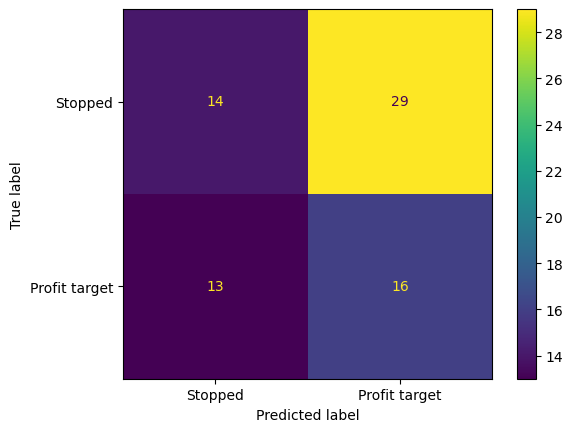

In [101]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

In [102]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $382.5
This resulted in a net profit of $-1759.5 by implementing our machine learning model


In [103]:
#Set up our grid search
grid_values = {'hidden_layer_sizes': [[5,10,2],[5,10,3],[10,5,2]],
               'alpha': [0.01,0.1,1,5,10]}
clf = MLPClassifier(max_iter=8000,solver='lbfgs',random_state = model_seed)
grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring=scoring)
grid_clf.fit(X_train,y_train)
print(f"Best {scoring}: {grid_clf.best_score_}")
print(f"Best Params: {grid_clf.best_params_}")

Best recall: 0.5264492753623189
Best Params: {'alpha': 0.1, 'hidden_layer_sizes': [10, 5, 2]}


In [104]:
#Let's pull out the model that was the best estimator here
best_model = grid_clf.best_estimator_
#Now, let's see how it performs based on the test data
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
model_scores2 = pd.DataFrame([{'Model':'Deep Neural Network','Accuracy':np.round(accuracy_score(y_test,y_pred),3), 'Precision':np.round(precision_score(y_test,y_pred),3),'Recall':np.round(recall_score(y_test,y_pred),3),'ROCAUC':np.round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)}])
model_scores = pd.concat([model_scores,model_scores2],ignore_index=True)
model_scores

,Model,Accuracy,Precision,Recall,ROCAUC
0,Dummy Majority,0.597,0.000,0.000,0.500
1,Dummy Stratified,0.500,0.405,0.517,0.503
2,Logistic Regression,0.403,0.403,1.000,0.500
3,Support Vector Machine,0.500,0.379,0.379,0.500
4,Random Forest,0.542,0.400,0.276,0.427
5,Gradient Boosted Trees,0.514,0.364,0.276,0.412
6,Shallow Neural Network,0.417,0.356,0.552,0.431
7,Deep Neural Network,0.444,0.333,0.379,0.435


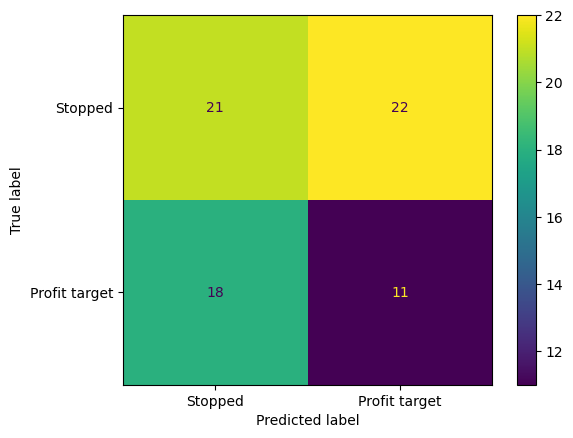

In [105]:
def plot_confusion(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    labels = {"Stopped": 0, "Profit target": 1}.keys()
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display_cm.plot()
    plt.show()
plot_confusion(y_test,y_pred)

In [106]:
transaction_fee = 1.50
risk = 150
reward = 2 * risk
winrate = (1 - model_scores.iloc[0,1]).round(4)
total_trades = conf_matrix.sum()
#Calculate the net profit without using a model
fees = total_trades * transaction_fee
net_profit_nomodel = (reward * np.floor((total_trades * winrate))) - (risk * np.ceil((total_trades * (1 - winrate)))) - fees
print(f"The net profit of the strategy after {total_trades} days is approximately ${np.round(net_profit_nomodel,2)}")
#With model
new_total_trades = conf_matrix[0,1] + conf_matrix[1,1]
fees = new_total_trades * transaction_fee
net_profit_model = (reward * conf_matrix[1,1]) - (risk * conf_matrix[0,1]) - fees
print(f"The net profit of the model after {total_trades} days is approximately ${np.round(net_profit_model,2)}")
print(f"This resulted in a net profit of ${np.round(net_profit_model,2)-np.round(net_profit_nomodel,2)} by implementing our machine learning model")

The net profit of the strategy after 72 days is approximately $2142.0
The net profit of the model after 72 days is approximately $-49.5
This resulted in a net profit of $-2191.5 by implementing our machine learning model


## Section 6: Conclusions
It is interesting to note that with the features we have chosen, none beat the random nature of just taking every trade regardless of what the outcome will be. Machine learning doesn't always give you insights but this gives us a general framework of how we can add features for a machine learning model in practice.